# Quick start

This notebook provides an example on how to use *cobamp* to easily calculate elementary flux modes (EFMs) and minimal cut sets (MCSs) coupled with the model reading and flux analysis capabilities of the *COBRApy* package.

## Model reading and setup

Download the model in SBML format from the BiGG models repository. In this example we use the central carbon metabolic model of *Escherichia coli*, downloaded and stored in a temporary folder/path stored as *model_path*.

In [1]:
import urllib

model_url = "http://bigg.ucsd.edu/static/models/e_coli_core.xml"
model_path, model_content = urllib.request.urlretrieve(model_url)

Read the SBML temporary file generated from the HTTP request content and generate a COBRA Model object from it. Two functions are defined to assist in further analyses:
* *restore_bounds()* - restores all reaction bounds to their original values
* *apply_kos(**kos**)* - knockout reactions contained in *kos* (any iterable containing reaction IDs)

In [2]:
import cobra

model = cobra.io.sbml.read_sbml_model(model_path)
model_bounds = {r.id:(r.lower_bound, r.upper_bound) for r in model.reactions}

# >>> model_bounds
# ... {'ACALD': (-1000.0, 1000.0),
# ... 'ACALDt': (-1000.0, 1000.0),
# ... 'ACKr': (-1000.0, 1000.0),
# ... 'ACONTa': (-1000.0, 1000.0),
# ... 'ACONTb': (-1000.0, 1000.0), ...

def restore_bounds():
    for r in model.reactions:
        r.lower_bound, r.upper_bound = model_bounds[r.id]

def apply_kos(kos):
    for ko in kos:
        model.reactions.get_by_id(ko).knock_out()
        
model

Name,e_coli_core
Memory address,0x07f6bbab80588
Number of metabolites,72
Number of reactions,95
Objective expression,1.0*BIOMASS_Ecoli_core_w_GAM - 1.0*BIOMASS_Ecoli_core_w_GAM_reverse_712e5
Compartments,"extracellular space, cytosol"


Extracting environmental conditions from this particular model, assuming the maximum capacity constant $N$ ($N=1000$). This assumes the media is defined when a lower or upper bound is different than 0, $N$ or $-N$.

This will be needed some steps further for the MCSEnumerator approach.

In [3]:
env_conditions = {r.id:(r.lower_bound, r.upper_bound) 
 for r in model.reactions 
 if (r.lower_bound not in [-1000, 0]) or (r.upper_bound not in [0, 1000])}

env_conditions

{'ATPM': (8.39, 1000.0), 'EX_glc__D_e': (-10.0, 1000.0)}

## Enumerating minimal cut sets

Import the MCSEnumerator wrapper class (*KShortestMCSEnumeratorWrapper*) that works with COBRA models. *KShortestMCSEnumeratorWrapper* provides a simple interface to enumerate minimal cut sets (MCSs) using the K-shortest algorithm (commonly referred to as the MCSEnumerator approach).

MCSs are sets of reactions that disable a certain phenotype in a model. This phenotype is defined as a set of flux or yield constraints. In this example, we will enumerate some MCSs.

In [4]:
from cobamp.wrappers import KShortestMCSEnumeratorWrapper

Define the region of the flux space that the MCSs are supposed to block. In this scenario, we are attempting to improve succinate production using glucose as a carbon source. The following reaction IDs are required:
* Succinate exchange : 'EX_succ_e'
* Glucose exchange: 'EX_glc__D_e'
* Maintenance ATP: 'ATPM'

As such, we wish to block low production phenotypes by adding a lower bound on the yield between succinate and glucose. Since the latter is only consumed, we assume its flux value is always negative. Thus, we want yields to be as low as possible, hence the lower bound definition.

This yield constraint can be loosely represented as the following:

$Y\frac{succinate}{glucose} > -0.001$

MCSs will block this phenotype and thus, we will obtain negative yields.

In [5]:
yield_space = {
   #('product_id'),('substrate_id'):(lower_bound, upper_bound, deviation - set to zero for most cases)
    ('EX_succ_e','EX_glc__D_e'):(-0.001, None, 0), 
}

flux_space = {
   # flux id     : (lower_bound, upper_bound)
    'EX_glc__D_e': (-10, None),
    'ATPM' : (8.39, None)
}

Having defined the flux space, we can now start the algorithm. The wrapper for MCSEnumerator requires the following parameters:
* *model*: A model instance from *COBRA*, *framed* (or any other framework if a *ModelReader* subclass is implemented for it and added to the list of readers)
* *target_flux_space_dict*: A dictionary (str -> tuple(float, float)) mapping reaction identifiers to flux bounds representing the target flux space for minimal cut sets.
* *target_yield_space_dict*: A dictionary ((str, str) -> tuple(float, float, float)) mapping product/substrate pairs to a lower and upper bound for the yield constraint between both fluxes and a deviation value for the constraint.
* *algorithm_type*: Can be one of two values:
    * *KShortestMCSEnumeratorWrapper.ALGORITHM_TYPE_POPULATE*: Enumerate one size at a time
    * *KShortestMCSEnumeratorWrapper.ALGORITHM_TYPE_ITERATIVE*: Enumerate one solution at a time
* *stop_criteria*: An integer defining the maximum number of iterations. If the *POPULATE* routine is used, the algorithm will yield all solutions that have size *stop_criteria* and below. On the other hand, if *ITERATIVE* is used, the algorithm will yield the *stop_criteria*-shortest solutions.
* *solver*: A string that specifies the solver to be used

It is worth noting that CPLEX is currently the best alternative for elementary mode enumeration due to some limitation on both the solvers and the *optlang* framework.

With CPLEX, *cobamp* uses indicator constraints, while other solvers (GLPK and GUROBI) rely on Big-M formulations. The latter requires a parameter (M), which is to be set at a very large value. However, higher values of M result in numerical instability which negatively affects the solutions yielded by the optimizer.

Indicator constraints can be used with GUROBI, although *optlang* does not currently support their addition. If these features are implemented in *optlang*, *cobamp* will also support them.


In [6]:
ksefm = KShortestMCSEnumeratorWrapper(
    model=model,
    target_flux_space_dict=flux_space, 
    target_yield_space_dict=yield_space, 
    algorithm_type=KShortestMCSEnumeratorWrapper.ALGORITHM_TYPE_POPULATE, 
    stop_criteria=5,
	solver='CPLEX') # or 'GUROBI', 'GLPK'

The MILP problems aren't actually run once the KShortestMCSEnumeratorWrapper instance is created. To obtain the solutions, the *get_enumerator()* method must be called. This method returns a generator that can be called in several ways.

In [7]:
enumerator = ksefm.get_enumerator()

Depending on time constraints, one can interactively call the *next* function on the enumerator so it iterates just once. This is useful when the problem is large or when exploring new constraints.

In [8]:
solutions = [sol for sol in enumerator]

Solutions are always lists of dictionaries mapping fluxes with values for all active fluxes. For MCSs, one simply has to obtain the dictionary keys for all dictionaries in the list.

In [9]:
solutions[0]

[{'ENO': 1548.6591179977859},
 {'NADH16': 357.40166865316615},
 {'GAPD': 1548.5399284864625},
 {'PGK': -1548.5399284864627},
 {'PGM': -1548.6591179977856},
 {'GLCpts': 2.324195470798569},
 {'EX_glc__D_e': -2.0858164481525625},
 {'EX_succ_e': 2084.743742550656},
 {'EX_h2o_e': 1131.6895113231285},
 {'H2Ot': -1131.6895113231285},
 {'SUCCt3': 2084.743742550656},
 {'EX_h_e': 1042.3718712753266},
 {'ATPM': 1.0}]

In [10]:
mcs = [set(d.keys()) for d in solutions[0]]
mcs

[{'ENO'},
 {'NADH16'},
 {'GAPD'},
 {'PGK'},
 {'PGM'},
 {'GLCpts'},
 {'EX_glc__D_e'},
 {'EX_succ_e'},
 {'EX_h2o_e'},
 {'H2Ot'},
 {'SUCCt3'},
 {'EX_h_e'},
 {'ATPM'}]

Unlike the previous approach, we can try and extensively enumerate all MCSs. We must redefine the enumerator as it already iterated once. We can import the *chain* function and use it to get a list of solutions until the stop criteria is reached.

In [11]:
enumerator = ksefm.get_enumerator()

In [12]:
from itertools import chain
solutions = list(chain(*ksefm.get_enumerator()))

In [13]:
mcs = [set(e.keys()) for e in solutions]
mcs[1:20]

[{'NADH16'},
 {'GAPD'},
 {'PGK'},
 {'PGM'},
 {'GLCpts'},
 {'EX_glc__D_e'},
 {'EX_succ_e'},
 {'EX_h2o_e'},
 {'H2Ot'},
 {'SUCCt3'},
 {'EX_h_e'},
 {'ATPM'},
 {'NADTRHD', 'PFK'},
 {'EX_co2_e', 'TPI'},
 {'G6PDH2r', 'PGI'},
 {'CO2t', 'TPI'},
 {'PGI', 'PGL'},
 {'CYTBD', 'FBA'},
 {'PGI', 'RPE'}]

## Enumerating elementary flux modes

We can import the *KShortestEFMEnumeratorWrapper* to enumerate elementary flux modes (EFMs) using the K-shortest EFM algorithm.

EFMs can be considered as the smallest functional units in a metabolic model that can achieve a certain function and are useful in finding novel metabolic functions.

In [14]:
from cobamp.wrappers import KShortestEFMEnumeratorWrapper

For this example, we will enumerate EFMs in the model we have previously loaded. Similarly to the example above, we intend to produce succinate with this organism. For that purpose, we will try to enumerate the smallest EFMs that allow the conversion of glucose into succinate and biomass (to ensure growth).

To specify these metabolites, they have to be present in the model. First, we will create a metabolite to represent cell growth.
We then add a reaction to represent the fictional secretion of this metabolite. Both components are added to a copy of the model to preserve the original version.

In [15]:
biomass_c = cobra.Metabolite(compartment='c', id='biomass_c', name='Biomass')
biomass_production = cobra.Reaction(id='EX_biomass_e', name='Biomass production', lower_bound=0, upper_bound=1000)

model_biomass = model.copy()
model_biomass.add_metabolites([biomass_c])

The biomass metabolite is added to the biomass reaction already present in the model as a product.
On the new reaction, the same metabolite is added as a reactant, effectively creating a drain on the model.

In [16]:
model_biomass.reactions.BIOMASS_Ecoli_core_w_GAM.add_metabolites({biomass_c: 1})
biomass_production.add_metabolites({biomass_c: -1})

The K-shortest enumeration algorithm is then instantiated using mostly the same arguments as in the example above, with the addition of:
* *consumed* : A list of metabolite IDs that are guaranteed to be consumed by the cell
* *non_consumed*: A list of external metabolite IDs that cannot be consumed
* *produced* : A list of external metabolite IDs that must be produced by the cell

These parameters are used to narrow the space of possible EFMs to avoid unwanted metabolic functions and speed up the search.

In [17]:
ksefm = KShortestEFMEnumeratorWrapper(
    model=model_biomass,
    non_consumed=[],
    consumed=['glc__D_e'],
    produced=['biomass_c','succ_e'],
    algorithm_type=KShortestEFMEnumeratorWrapper.ALGORITHM_TYPE_POPULATE,
    stop_criteria=100,
	solver='CPLEX'
)

Having set a limit of 100 for the size of the EFMs, we will now attempt to enumerate them. In this example we will only obtain with the smallest. Once the algorithm reaches first iteration that yields at least one EFM, we will no longer call the *enumerator* instance.

In [18]:
enumerator = ksefm.get_enumerator()

efm_list = []
while len(efm_list) == 0:
    efm_list += next(enumerator)

The 17 smallest EFMs include 42 reactions

In [19]:
len(efm_list)

17

## Analysis of elementary flux modes
### Inspecting flux coefficients

The EFMs can be displayed as a set of reactions with coefficients. Please note that the drains that correspond with the external metabolites defined as being consumed or produced will not show up as active reactions, even though they are part of the EFM. This occurs since the mass balance equation for these metabolites is changed from
$\sum^{n}_{j=1}{S_{ij}}v = 0$ to $\sum^{n}_{j=1}{S_{ij}}v > 1$ or $\sum^{n}_{j=1}{S_{ij}}v < -1$, assuming $v$ as the flux vector.

The values for these fluxes can be calculated by replacing $v$ with the flux values from the EFM and obtaining the result from the left hand side of the inequation

In [20]:
efm_list[0]

{'ACONTa': 509.7485477179139,
 'ACONTb': 509.7485477179139,
 'AKGDH': 491.84149377600266,
 'BIOMASS_Ecoli_core_w_GAM': 16.597510373446326,
 'CO2t': -1034.139419087282,
 'CS': 509.7485477179139,
 'CYTBD': 2521.7435684650845,
 'ENO': 1166.9892116184212,
 'EX_co2_e': 1034.139419087282,
 'EX_h2o_e': 1646.8838174276166,
 'EX_h_e': 1316.6290456433399,
 'EX_nh4_e': -90.50290456432813,
 'EX_o2_e': -1260.8717842325423,
 'EX_pi_e': -61.05726141079617,
 'FBA': 601.4605809129475,
 'GAPD': 1191.8190871370969,
 'GLCpts': 617.9701244814147,
 'GLNS': 90.50290456432813,
 'GLUSy': 86.2589211618379,
 'H2Ot': -1646.8838174276166,
 'ICDHyr': 509.7485477179139,
 'NADH16': 2521.7435684650845,
 'NADTRHD': 5576.853941909496,
 'NH4t': 90.50290456432813,
 'O2t': 1260.8717842325423,
 'PDH': 571.952697095516,
 'PFK': 601.4605809129475,
 'PGI': 614.5676348548582,
 'PGK': -1191.8190871370969,
 'PGM': -1166.9892116184212,
 'PIt2r': 61.05726141079617,
 'PPC': 539.4033195021505,
 'PYK': 1.0,
 'RPE': -11.93029045643322,

In [21]:
metabolite = model_biomass.metabolites.biomass_c
cur_efm = efm_list[0]
{r:cur_efm[r.id] for r in metabolite.reactions if r.id in cur_efm}

{<Reaction BIOMASS_Ecoli_core_w_GAM at 0x7f6b7bff8780>: 16.597510373446326}

### Visualizing EFMs in metabolic maps
Alternatively, external packages can be used to provide a more interactive result. The *escher* package (https://escher.github.io/), once installed in your Python distribution, can be used to display metabolic maps. The snippet below shows how the EFMs from *cobamp* can be used directly as inputs for *escher* maps.

In [22]:
import escher

escher_builder = escher.Builder(
    map_name='e_coli_core.Core metabolism', # map that matches our model
    reaction_scale=[{'type': 'min', 'color': '#0000ff', 'size': 10}, # make active fluxes more visible
               {'type': 'mean', 'color': '#551a8b', 'size': 20},
               {'type': 'max', 'color': '#ff0000', 'size': 40}],

    hide_secondary_metabolites = True,
    reaction_data = efm_list[0], # provides flux values from the first EFM 
    
)
escher_builder.display_in_notebook(js_source='web')

### Representing multiple EFMs as trees

Additionally, we can also display EFMs as ordered trees where each path from the root to a leaf is a single EFM. This allows us to observe patterns among large sets of EFMs to identify common mechanisms between them

The *analysis.tree* module contains some functions to achieve this. Please note that this functionality is still highly experimental

In [23]:
from cobamp.analysis.graph import *

The function below provides an example workflow to organize EFMs (or MCSs) as trees

Firstly, the root node is created and the tree is populated with the EFMs. This procedure is performed by iteratively adding one node representing the most common reaction within a the set of EFMs. Each of these nodes is then recursively populated using the subset of EFMs containing reactions from the nodes above it.

The tree is then compressed by merging linear sequences of nodes into a single node whose value is a list of reactions. This list is then converted to a concatenated string for easier reading.

If needed, very large nodes can be ignored, with their value set to an arbitrary value. Additionally the tree can be pruned below a supplied depth value, replacing all nodes below it by the relative frequency of each reaction in the set of EFMs represented under these new leaves.

In [24]:
def generate_efm_results_tree(efm_sets, ignore_greater_than=10, pruning_level=6, merge_dupes=False):
    root = Tree('ROOT')
    # fill the tree with EFMs
    fill_tree(root, efm_sets)
    # compress sequences of nodes with only 1 inward and 1 outward edge
    compress_linear_paths(root) 
    if ignore_greater_than:
        ignore_compressed_nodes_by_size(root, ignore_greater_than) # if a node has too many fluxes, ignore it
        
    # apply a function to all nodes in this example, the node value 
    # is converted to a string if it is currently a list of strings
    # this is the case of compressed nodes
    apply_fx_to_all_node_values(root, lambda x: ' + '.join(sorted(x)) if isinstance(x, list) else x if x is not None else "None")
    
    # if the tree is too deep, a depth value can be specified
    # so the tree is cut past that point
    # the leaf that replaces it will specify the relative
    # frequency of the reactions in all EFMs represented by it
    if pruning_level:
        probabilistic_tree_prune(root, target_level=pruning_level, cut_leaves=False, name_separator='+')
    
    # compress the tree again
    compress_linear_paths(root)
    
    # merge duplicate nodes. this effectively replaces all
    # objects of the same value with a single object
    if merge_dupes:
        merge_duplicate_nodes(root)
    return root

The tree is then generated using this function, returning the populated *tree* object

In [25]:
tree = generate_efm_results_tree(
    efm_sets=efm_list, # list of elementary modes (list[dict[str,float]])
    ignore_greater_than=None, # ignore nodes with more than *ignore_greater_than* elements
    pruning_level=None, # prune tree from the nodes past depth=*pruning_level*
    merge_dupes=False # do not merge duplicate nodes
)

A simple print function is supplied to quickly view the tree.

In [26]:
print(pretty_print_tree(tree))

|-- ACONTa + ACONTb + AKGDH + BIOMASS_Ecoli_core_w_GAM + CO2t + CS + CYTBD + ENO + EX_co2_e + EX_h2o_e + EX_h_e + EX_nh4_e + EX_o2_e + EX_pi_e + FBA + GAPD + GLCpts + GLNS + H2Ot + ICDHyr + NADH16 + NH4t + O2t + PDH + PFK + PGI + PGK + PGM + PIt2r + PPC + PYK + ROOT + RPE + RPI + SUCCt3 + SUCOAS + TALA + TKT1 + TKT2 + TPI(None)
|	|-- ATPS4r(13)
|	|	|-- GLUSy(7)
|	|	|	|-- GLUDy(1)
|	|	|	|-- SUCCt2_2(1)
|	|	|	|-- FBP(1)
|	|	|	|-- ATPM(1)
|	|	|	|-- GLUN(1)
|	|	|	|-- THD2(1)
|	|	|	|-- PPCK(1)
|	|	|-- GLUDy(6)
|	|	|	|-- SUCCt2_2(1)
|	|	|	|-- FBP(1)
|	|	|	|-- ATPM(1)
|	|	|	|-- GLUN(1)
|	|	|	|-- THD2(1)
|	|	|	|-- PPCK(1)
|	|-- NADTRHD(4)
|	|	|-- GLUSy(2)
|	|	|	|-- SUCCt2_2(1)
|	|	|	|-- THD2(1)
|	|	|-- GLUDy(2)
|	|	|	|-- SUCCt2_2(1)
|	|	|	|-- THD2(1)


Another way to draw this would be to used the NetworkX (https://networkx.github.io/) with GraphViz (https://www.graphviz.org/) installed.

Old root string: ACONTa + ACONTb + AKGDH + BIOMASS_Ecoli_core_w_GAM + CO2t + CS + CYTBD + ENO + EX_co2_e + EX_h2o_e + EX_h_e + EX_nh4_e + EX_o2_e + EX_pi_e + FBA + GAPD + GLCpts + GLNS + H2Ot + ICDHyr + NADH16 + NH4t + O2t + PDH + PFK + PGI + PGK + PGM + PIt2r + PPC + PYK + ROOT + RPE + RPI + SUCCt3 + SUCOAS + TALA + TKT1 + TKT2 + TPI


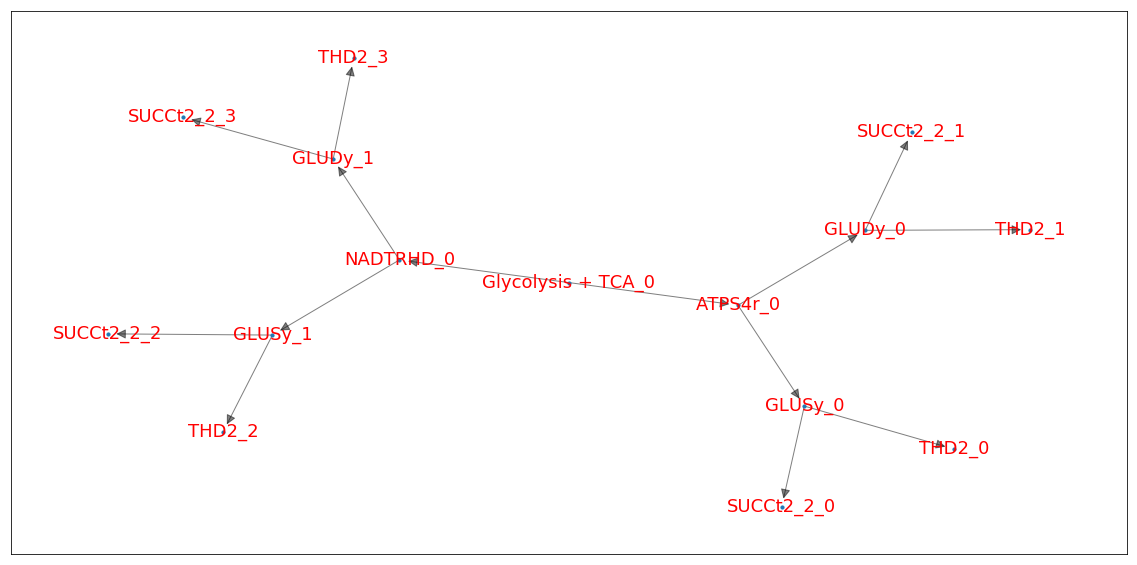

In [27]:
%matplotlib inline

tree = generate_efm_results_tree(
    efm_sets=efm_list, # list of elementary modes (list[dict[str,float]])
    ignore_greater_than=10, # ignore nodes with more than *ignore_greater_than* elements
    pruning_level=10, # prune tree from the nodes past depth=*pruning_level*
    merge_dupes=True # do not merge duplicate nodes
)

old_value = tree.value # save the old value of the root node
print('Old root string:', tree.value)
tree.value = "Glycolysis + TCA" # change the root node value to a shorter string

import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph() # define a new networkx Graph object
populate_nx_graph(tree, G, unique_nodes=True) # populate it with data from the Tree object

pos = nx.nx_pydot.graphviz_layout(G) # generate the graphviz layout

# create a figure and plot the nodes, edges and labels
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.5, arrowsize=20)
nx.draw_networkx_labels(G, pos, font_size=18, font_color='red')

plt.show()

### Frequency analysis of multiple sets of EFMs

Heatmaps can be used as graphical representations of matrices. If multiple sets of EFMs are enumerated using different conditions, they can be compared in terms of the frequency at which their active reactions are displayed. *cobamp* provides a simple analysis function to generate a *pandas* dataframe containing reaction frequencies for one or more sets of EFMs.

A dictionary mapping a group identifier (as string) and a set of reaction indices from the EFMs is required as input.

Firstly, the heatmap and frequency dataframe generating functions must be imported as shown below

In [28]:
from cobamp.analysis.plotting import display_heatmap
from cobamp.analysis.frequency import get_frequency_dataframe

As an example, one can try to enumerate the 50 smallest EFMs for consuming glucose and producing a wide array of interesting compounds as well as ensuring cell growth through the production of biomass. In this test case, we will try to get at least 50 EFMs to produce:
* Succinate (succ_e)
* D-Lactate (lac__D_e)
* Glutamine (gln__L_e)
* Glutamate (glu__L_e)
* Ethanol (etoh_e)

Some functions should be defined to achieve this specific purpose. First, we can generalize the EFM enumerators that were previously used to accept any product. The function *get_efm_enumerator_for_product(**model**, **product**)* returns an EFM enumerator for the **model** while forcing **product** to be secreted.

In [29]:
def get_efm_enumerator_for_product(model, product):
    ksefm = KShortestEFMEnumeratorWrapper(
        model=model,
        non_consumed=[],
        consumed=['glc__D_e'],
        produced=['biomass_c', product],
        algorithm_type=KShortestEFMEnumeratorWrapper.ALGORITHM_TYPE_POPULATE,
        stop_criteria=100,
		solver='CPLEX'
    )
    
    return ksefm.get_enumerator()

Another function can also be created to obtain at least 50 EFMs and convert them to sets of reactions. This function, *get_production_efms(**model**, **product**)*, calls the function defined above to obtain the enumerator and enumerates EFM up to size 100 but stops if 50 EFMs have been added.

In [30]:
def get_production_efms(model, product):
    enumerator = get_efm_enumerator_for_product(model, product)
    efm_list = []
    stopped = False
    
    while len(efm_list) < 50 and not stopped:
        try:
            efm_list += next(enumerator)
        except StopIteration as si:
            stopped = True
            print('Stopping criteria reached!')
            
    return [set(efm.keys()) for efm in efm_list]

Finally, we can define the desired products and enumerate the EFMs for each. A dictionary mapping products and EFMs is the preferred format for storing and analysing these EFMs.

In [31]:
products = ['succ_e','lac__D_e','gln__L_e','glu__L_e','etoh_e']

production_efms = {product:get_production_efms(model_biomass, product) for product in products}

Stopping criteria reached!


The enumerated EFMs for each product can be summarized in terms on reaction frequencies for each product. The function *get_frequency_dataframe(**efm_groups**)* from the *frequency* submodule accepts the dictionaries created above and generates a dataframe. Further preprocessing using other methods can enhance this analysis.

In [32]:
efm_df = get_frequency_dataframe(production_efms) # obtain the dataframe
efm_df = efm_df.loc[:,~ efm_df.isna().all()].fillna(0).astype(int) # remove entirely null columns (with no EFMs)

# convert absolute to relative frequency in percentage values
efm_df = efm_df * 100 / [len(production_efms[col]) for col in efm_df.columns]
efm_df

,etoh_e,glu__L_e,lac__D_e,succ_e
ACALD,100.000000,3.448276,1.481481,0.000000
ACALDt,0.523560,3.448276,1.481481,0.000000
ACONTa,100.000000,100.000000,100.000000,100.000000
ACONTb,100.000000,100.000000,100.000000,100.000000
ADK1,6.806283,29.655172,9.629630,6.060606
AKGDH,0.000000,0.689655,0.000000,36.363636
AKGt2r,13.612565,25.517241,28.148148,0.000000
ALCD2x,100.000000,0.000000,0.000000,0.000000
ATPM,7.329843,6.206897,4.444444,7.272727
ATPS4r,49.214660,64.827586,56.296296,63.030303


For the purpose of this tutorial, we are only interested in the differences between EFMs for different products and thus, we will only consider rows (reactions) whose frequency is variable amongst products.

In this example, we identify the 20 reactions with highest variance and subset the dataframe to be represented as a heatmap.

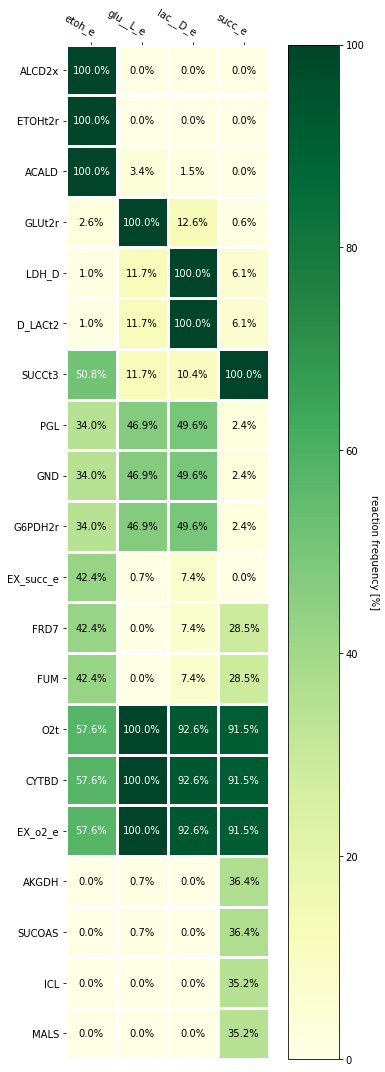

In [33]:
variance = efm_df.T.apply(lambda x: x.var())
high_variance = variance.sort_values(ascending= False).iloc[:20]
display_heatmap(efm_df.loc[high_variance.index,:])

## Constraint-based analysis of mutant phenotypes

With MCSs stored as dictionaries, we can easily use COBRA to analyse these knockouts. In this snippet, a dictionary is created to store various simulation values (Flux Balance/Variability Analysis) obtained after applying the reaction knockouts suggested by the MCSs. These are:
* *product_minimum* and *product_maximum* - Flux range for succinate production
* *max_growth* - Maximum growth rate
* *product_at_max_growth* - Predicted production rate at maximum growth
* *glucose_consumption* - Glucose consumption rate at maximum growth

In [34]:
def analyse(kos):
    apply_kos(kos)
    try:
        # Flux Balance Analysis
        sol = model.optimize()

        biomass = sol.fluxes.BIOMASS_Ecoli_core_w_GAM
        product = sol.fluxes.EX_succ_e
        substrate = sol.fluxes.EX_glc__D_e
        
        # Flux Variability Analysis
        fva = cobra.flux_analysis.variability.flux_variability_analysis(
            model, reaction_list=['EX_succ_e']).loc['EX_succ_e',:]
        
        return {
        'product_maximum': fva['maximum'],
        'product_minimum': fva['minimum'],
        'max_growth': biomass,
        'product_at_max_growth':product,
        'glucose_consumption': substrate
        }
    
    except:
        pass
    finally:
        # restore reaction bounds to their original state
        # so the next iteration applies knockouts over them
        restore_bounds()
    return 

*pandas* can be used to store these values as a dataframe for easier manipulation and analysis 

In [35]:
import pandas as pd

df = pd.DataFrame({frozenset(ko): analyse(ko) for ko in mcs}).T

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


Solutions with null or very low growth, as well as solutions with very low production rates are filtered out. This way, only the best candidates are displayed

In [36]:
null_growth = df.max_growth.isnull() # growth is None - due to infeasibility
zero_growth = df.max_growth <= 1e-10 # growth is too low (near 0)
no_product = df.product_at_max_growth <= 1e-5 # no production at maximum biomass

df.index.names = ['knockouts']

df[~ (zero_growth | null_growth | no_product)].sort_values(by='max_growth', ascending=False).iloc[1:20,:]

,glucose_consumption,max_growth,product_at_max_growth,product_maximum,product_minimum
knockouts,,,,,
"(PPS, LDH_D, ACALD, CYTBD, PYRt2)",-10,0.110886,9.09864,9.09864,9.09864
"(PPS, D_LACt2, PYRt2, CYTBD, ACALD)",-10,0.110886,9.09864,9.09864,9.09864
"(PYRt2, PPS, EX_lac__D_e, CYTBD, ACALD)",-10,0.110886,9.09864,9.09864,9.09864
"(PYRt2, PPS, EX_lac__D_e, O2t, ACALD)",-10,0.110886,9.09864,9.09864,9.09864
"(PYRt2, ADK1, EX_lac__D_e, EX_o2_e, ACALD)",-10,0.110886,9.09864,9.09864,9.09864
"(PYRt2, ADK1, EX_lac__D_e, O2t, ACALD)",-10,0.110886,9.09864,9.09864,9.09864
"(O2t, LDH_D, ADK1, ACALD, EX_pyr_e)",-10,0.110886,9.09864,9.09864,9.09864
"(LDH_D, ADK1, ACALD, EX_o2_e, EX_pyr_e)",-10,0.110886,9.09864,9.09864,9.09864
"(PYRt2, LDH_D, ADK1, ACALD, EX_o2_e)",-10,0.110886,9.09864,9.09864,9.09864
